## Import the data

In [1]:
import pandas as pd
import numpy as np

import re
import nltk
nltk.download('punkt')
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DK23\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Loading data

In [2]:
data = pd.read_csv('E:\Final_Data.csv', index_col=0)
data
#data.info()

,Title,Content
0,punishment crimes committed substance susch co...,person kills attempts cause death child woman ...
1,punishment abduction wimen children,person human trafficking prevention suppressio...
2,punishment ransom,person detains woman child ransom person shall...
3,punishment rapem death due rape,man rapes woman child shall punishable death p...
4,punishment inciting women commit suicide,woman commits suicide without consent woman pe...
...,...,...
195,adulteration food drink intended sale,whoever adulterates article food drink make ar...
196,punishment theft,whoever commits theft shall punished imprisonm...
197,theft dwellinghouse etc,whoever commits theft building tent vessel bui...
198,theft preparation made causing death hurt rest...,whoever commits theft made preparation causing...


## Removing whoever

In [3]:
def clean_whoever(x):
    x = str(x).replace('whoever ', '')
    return x

In [4]:
data['Content'] = data['Content'].apply(lambda x: clean_whoever(x))

In [10]:
data

,Title,Content
0,punishment crimes committed substance susch co...,person kills attempts cause death child woman ...
1,punishment abduction wimen children,person human trafficking prevention suppressio...
2,punishment ransom,person detains woman child ransom person shall...
3,punishment rapem death due rape,man rapes woman child shall punishable death p...
4,punishment inciting women commit suicide,woman commits suicide without consent woman pe...
...,...,...
195,adulteration food drink intended sale,adulterates article food drink make article no...
196,punishment theft,commits theft shall punished imprisonment eith...
197,theft dwellinghouse etc,commits theft building tent vessel building te...
198,theft preparation made causing death hurt rest...,commits theft made preparation causing death h...


## Import for W2V

In [5]:
import pandas as pd
import gensim
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import os
import random
import re
import string

import nltk
import numpy as np
import pandas as pd

from gensim.models import Word2Vec

from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

## TBD

In [6]:
data_set = data.Content.apply(gensim.utils.simple_preprocess)
data_set

0      [person, kills, attempts, cause, death, child,...
1      [person, human, trafficking, prevention, suppr...
2      [person, detains, woman, child, ransom, person...
3      [man, rapes, woman, child, shall, punishable, ...
4      [woman, commits, suicide, without, consent, wo...
                             ...                        
195    [adulterates, article, food, drink, make, arti...
196    [commits, theft, shall, punished, imprisonment...
197    [commits, theft, building, tent, vessel, build...
198    [commits, theft, made, preparation, causing, d...
199    [clerk, servant, employed, capacity, clerk, se...
Name: Content, Length: 200, dtype: object

## W2V

In [7]:
from gensim.models import Word2Vec
model = Word2Vec(sentences=data_set, vector_size=100, workers=1, seed=25)

## Testing W2V

In [8]:
model.wv.most_similar("child")
#model.wv.similarity(w1="woman", w2="child")

[('order', 0.9992693662643433),
 ('section', 0.9992598295211792),
 ('shall', 0.9992567300796509),
 ('person', 0.9991907477378845),
 ('not', 0.9991630911827087),
 ('public', 0.9991371631622314),
 ('knows', 0.9991245865821838),
 ('purpose', 0.9991223812103271),
 ('property', 0.9991046190261841),
 ('servant', 0.9990956783294678)]

## W2V model

In [9]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
vectorized_docs = vectorize(data_set, model=model)
len(vectorized_docs), len(vectorized_docs[0])

(200, 100)

## Checking the optimal number of cluster

In [25]:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,50)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(vectorized_docs)
    Sum_of_squared_distances.append(km.inertia_)

C:\Users\DK23\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


## Ploting the figure

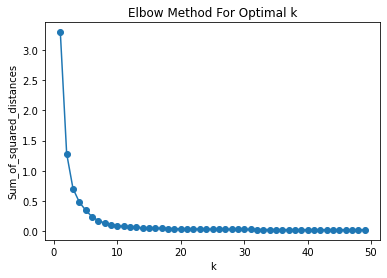

In [26]:
import matplotlib.pyplot as plt

plt.plot(K, Sum_of_squared_distances, marker='o')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## K-mean Cluster

In [31]:
def mbkmeans_clusters(
	X, 
    k, 
    mb, 
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

## Results

In [33]:
clustering, cluster_labels = mbkmeans_clusters(
	X=vectorized_docs,
    k=7,
    mb=500,
    print_silhouette_values=True,
)
df_clusters = pd.DataFrame({
    "text": "docs",
    "tokens": [" ".join(text) for text in data_set],
    "cluster": cluster_labels
})

For n_clusters = 7
Silhouette coefficient: 0.47
Inertia:0.17854864887382424
Silhouette values:
    Cluster 5: Size:7 | Avg:0.53 | Min:0.18 | Max: 0.67
    Cluster 1: Size:27 | Avg:0.52 | Min:0.09 | Max: 0.69
    Cluster 0: Size:44 | Avg:0.51 | Min:-0.07 | Max: 0.70
    Cluster 3: Size:28 | Avg:0.46 | Min:-0.11 | Max: 0.65
    Cluster 6: Size:35 | Avg:0.44 | Min:0.07 | Max: 0.68
    Cluster 2: Size:55 | Avg:0.44 | Min:0.04 | Max: 0.68
    Cluster 4: Size:4 | Avg:0.30 | Min:0.08 | Max: 0.56


C:\Users\DK23\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


## Data Labels

In [39]:
print("Most representative terms per cluster (based on centroids):")
for i in range(7):
    tokens_per_cluster = ""
    most_representative = model.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=10)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Most representative terms per cluster (based on centroids):
Cluster 0: shall person section not servant order purpose knows may knowing 
Cluster 1: person shall section servant purpose not order knows public knowing 
Cluster 2: shall person section servant not purpose order knows may knowing 
Cluster 3: shall person section not servant order purpose knows knowing public 
Cluster 4: person shall section not purpose servant knows order knowing used 
Cluster 5: person shall servant section public purpose not knows order knowing 
Cluster 6: shall person section not servant order purpose knows may public 


In [1]:
#df_clusters